In [1]:
# importing all required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyLDAvis import lda_model
import pickle
import pyLDAvis
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA


from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA



In [2]:
# creating connection
con = sqlite3.connect('./database.sqlite')
# extract the data from the Database
review_data = pd.read_sql_query("select * from Reviews",con)

# basic analysis
review_data.shape , display(review_data.head()) , review_data.info() , review_data.isna().any() , display(review_data.describe())

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568454 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568454 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


((568454, 10),
 None,
 None,
 Id                        False
 ProductId                 False
 UserId                    False
 ProfileName               False
 HelpfulnessNumerator      False
 HelpfulnessDenominator    False
 Score                     False
 Time                      False
 Summary                   False
 Text                      False
 dtype: bool,
 None)

In [3]:
# formatting the datas
# convert data to Datetime format
review_data["Time_Format"] = pd.to_datetime(review_data["Time"], unit="s")
# removing html tags
review_data["Text_Format"] = review_data["Text"].str.replace("<.+?>","")
# checking if numerator is greater than denominator
review_data["HelpfulnessNumerator"] = review_data[["HelpfulnessNumerator" , "HelpfulnessDenominator"]].min(axis=1)
review_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Time_Format,Text_Format
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,Great taffy at a great price. There was a wid...


In [4]:
#calculating length of each summary and text object
review_data["Summary_length"] = review_data["Summary"].str.split().map(len)
review_data["Text_length"] = review_data["Text_Format"].str.split().map(len)
# calculating helpfulness ratio
review_data["Helpfulness_ratio"] = review_data["HelpfulnessNumerator"] / review_data["HelpfulnessDenominator"]

review_data[["Text_length","Summary_length","Score","Helpfulness_ratio"]].describe()


,Text_length,Summary_length,Score,Helpfulness_ratio
count,568454.000000,568454.000000,568454.000000,298402.000000
mean,80.264023,4.113149,4.183199,0.776966
std,79.455384,2.597340,1.310436,0.346295
min,3.000000,1.000000,1.000000,0.000000
25%,33.000000,2.000000,4.000000,0.600000
50%,56.000000,4.000000,5.000000,1.000000
75%,98.000000,5.000000,5.000000,1.000000
max,3432.000000,42.000000,5.000000,1.000000


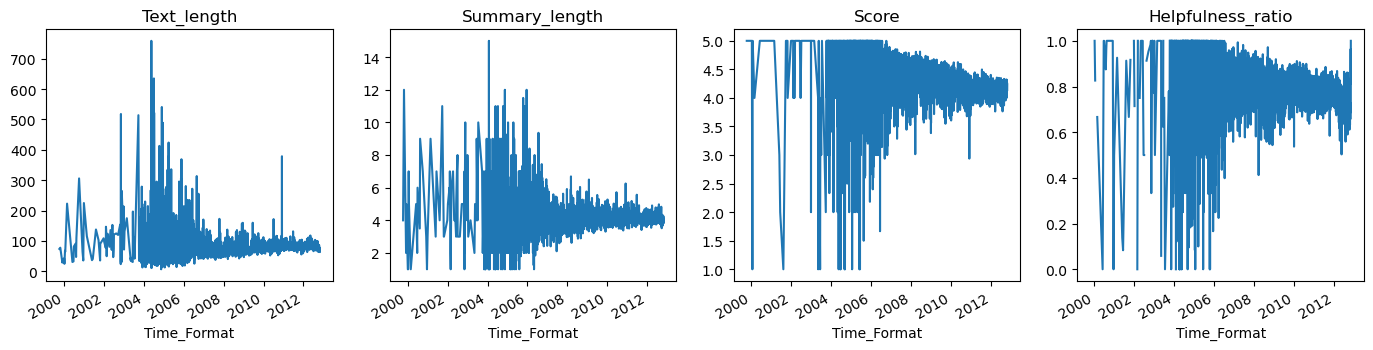

In [13]:
data = review_data[["Time_Format", "Text_length" , "Summary_length" , "Score" , "Helpfulness_ratio"]].groupby("Time_Format").mean()

plt.figure(figsize=(17,17))
for i, col in enumerate(data.columns, start=1):
    plt.subplot(4,4,i)
    data[col].plot()
    plt.title(col)

plt.show()


In [15]:
count_vectorizer = CountVectorizer(stop_words="english")
count_data = count_vectorizer.fit_transform(review_data["Text_Format"])
words = count_vectorizer.get_feature_names_out()
lda = LDA(n_components=5, n_jobs=-1, random_state=234)
lda.fit(count_data)



LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=234)

In [30]:
for idx , topic in enumerate(lda.components_):
    print("Topic %d" % idx)
    print([words[i] for i in topic.argsort()[::-1][:20]])

Topic 0
['like', 'good', 'great', 'taste', 'just', 'br', 'flavor', 'love', 'eat', 'chips', 'snack', 'product', 'salt', 'really', 'free', 'make', 'cookies', 'best', 'little', 'don']
Topic 1
['br', 'product', 'like', 'use', 'just', 'com', 'www', 'http', 'gp', 'href', 'amazon', 'oil', 'water', 'hair', 'don', 'good', 'hot', 'used', 'bottle', 'does']
Topic 2
['food', 'dog', 'br', 'cat', 'dogs', 'treats', 'like', 'eat', 'cats', 'loves', 'just', 'love', 'product', 'treat', 'good', 'old', 'great', 'time', 'little', 'chicken']
Topic 3
['like', 'taste', 'flavor', 'tea', 'just', 'good', 'water', 'sugar', 'drink', 'great', 'really', 'chocolate', 'love', 'sweet', 'product', 'milk', 'don', 'tastes', 'little', 'tried']
Topic 4
['coffee', 'tea', 'amazon', 'good', 'cup', 'great', 'like', 'price', 'product', 'flavor', 'just', 'taste', 'order', 'br', 'love', 'buy', 'box', 'cups', 'time', 'best']


In [7]:


ldavis_data_filepath = "./lda_visualization"

ldavis_prepared = lda_model.prepare(lda, count_data, count_vectorizer)
with open(ldavis_data_filepath, "wb") as f:
    pickle.dump(ldavis_prepared,f)

with open(ldavis_data_filepath,"rb") as f:
    ldavis_prepared = pickle.load(f)

pyLDAvis.save_html(ldavis_prepared,"./lda_visualization_report.html")

In [8]:
# sample_submission = pd.read_csv("sampleSubmission.csv", index_col="Id")

# test = review_data.loc[sample_submission.index]
# train = review_data.loc[~review_data.index.isin(sample_submission.index)]


In [5]:


# nltk.download(["punkt","stopwords","wordnet"])
STOPWORDS = stopwords.words("english")
LMTZR = WordNetLemmatizer()

STOPWORDS.append(set(['br','br br' 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]))


In [6]:
# function for formatting the each text point
def processing_text(data):
    summary , text = data["Summary"] , data["Text_Format"]
    summarytext = " ".join((summary,text))
    text_lower = re.sub("[^A-Za-z]"," ",summarytext.lower())
    tokenized_text = word_tokenize(text_lower)
    # removing the stopwords as well as lemmatizing each word 
    clean_text = (LMTZR.lemmatize(w) for w in tokenized_text if w not in STOPWORDS)
    return " ".join(clean_text)


review_text = review_data.apply(processing_text, axis=1)
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=327)
review_vectors = vectorizer.fit_transform(review_text)



In [7]:
review_text, vectorizer , list(review_vectors)

(0         good quality dog food bought several vitality ...
 1         advertised product arrived labeled jumbo salte...
 2         delight say confection around century light pi...
 3         cough medicine looking secret ingredient robit...
 4         great taffy great taffy great price wide assor...
                                 ...                        
 568449    without great sesame chicken good better restu...
 568450    disappointed disappointed flavor chocolate not...
 568451    perfect maltipoo star small give one training ...
 568452    favorite training reward treat best treat trai...
 568453    great honey satisfied product advertised use c...
 Length: 568454, dtype: object,
 TfidfVectorizer(max_features=327, ngram_range=(1, 3)),
 [<1x327 sparse matrix of type '<class 'numpy.float64'>'
  	with 14 stored elements in Compressed Sparse Row format>,
  <1x327 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format>,
  <1x3

In [11]:

pca = PCA(0.8, random_state=234)
# reducing dimensionality using PCA
reduced_vectors = pca.fit_transform(review_vectors.toarray())
print("no. of components/Dimensions", pca.n_components_)
pc1 = pd.Series(pca.components_[0,:], index=vectorizer.get_feature_names_out())
pc1.sort_values(inplace=True,ascending=False)
print("===================PC1==================")
print(pc1)
pc2 = pd.Series(pca.components_[1,:], index=vectorizer.get_feature_names_out())
pc2.sort_values(inplace=True,ascending=False)
print("===================PC2==================")
print(pc2)

no. of components/Dimensions 191
===================PC1==================
br            0.893512
br br         0.398676
food          0.036174
water         0.029943
ingredient    0.026305
                ...   
best         -0.029608
tea          -0.040352
love         -0.066854
coffee       -0.078097
great        -0.080771
Length: 327, dtype: float64
===================PC2==================


coffee    0.590878
tea       0.438593
cup       0.224992
flavor    0.101748
taste     0.092596
            ...   
love     -0.107479
cat      -0.157678
treat    -0.181534
food     -0.242042
dog      -0.369471
Length: 327, dtype: float64

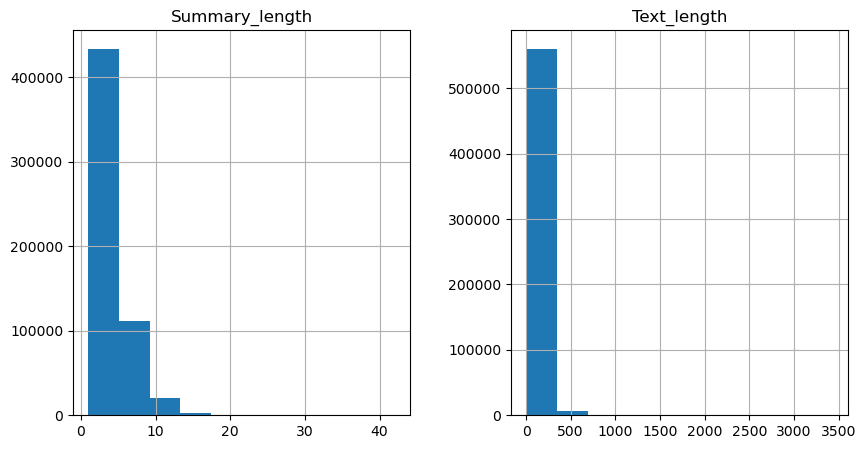

In [13]:
# checking the data skewness
review_data[["Summary_length","Text_length"]].hist(figsize=(10,5))
plt.show()

##### data seems a little bit left skewed

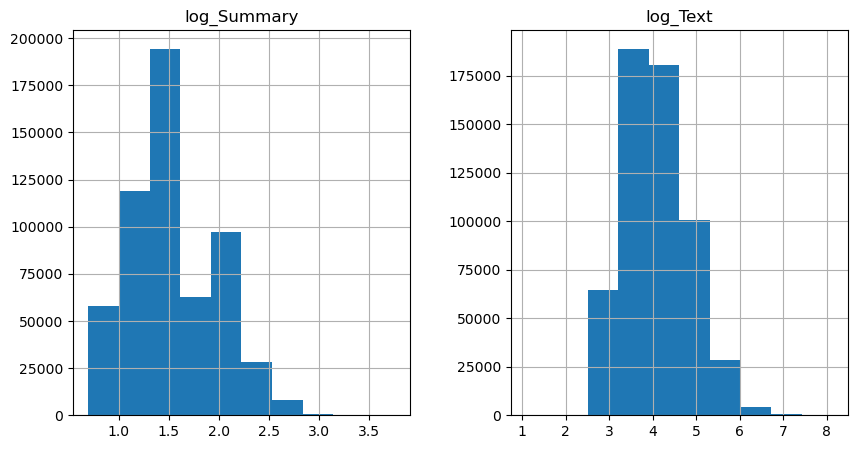

In [14]:
review_data["log_Summary"] = review_data["Summary_length"].apply(np.log1p)
review_data["log_Text"] = review_data["Text_length"].apply(np.log)
review_data[["log_Summary","log_Text"]].hist(figsize=(10,5))
plt.show()

/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/soumyajitpal/packages/miniconda3/envs/ml_dlai_metal/lib/python3.9/site-packages/seaborn/_oldc

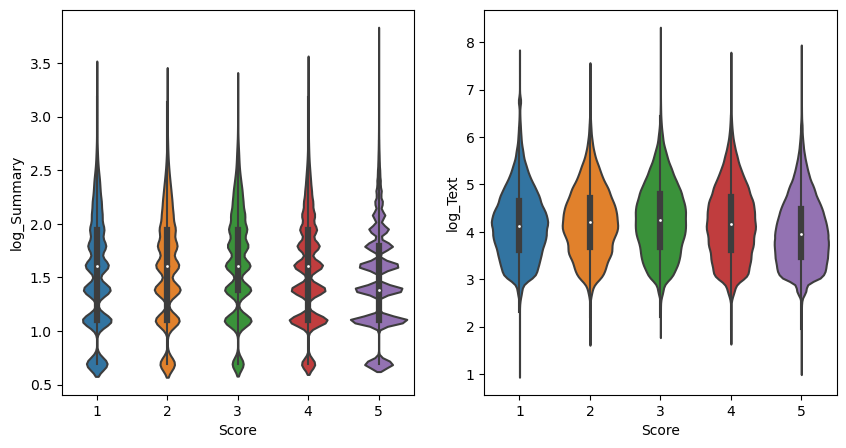

In [18]:

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.violinplot(x="Score",y="log_Summary",data=review_data)
plt.subplot(1,2,2)
sns.violinplot(x="Score",y="log_Text",data=review_data)
plt.show()

In [19]:
X_data = review_data.drop(['Score'],axis=1)
y_data = review_data[['Score']]
 

In [20]:
X = pd.DataFrame(reduced_vectors, index=X_data.index,
                 columns=["PC_{}".format(i) for i in range(1,pca.n_components_+1)])
X['HelpfulnessNumerator'] = X_data["HelpfulnessNumerator"]
X['Helpfulness_ratio'] = X_data['Helpfulness_ratio']
X["Yr_after2007"] = X_data["Time_Format"].dt.year.map(lambda year: max(year - 2007,0))
X["log_summary"] = X_data["Summary_length"].apply(np.log1p)
X["log_Text"] = X_data["Text_length"].apply(np.log)

In [21]:
X.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_187,PC_188,PC_189,PC_190,PC_191,HelpfulnessNumerator,Helpfulness_ratio,Yr_after2007,log_summary,log_Text
0,-0.066309,-0.273241,-0.014759,0.233629,0.031579,0.064796,0.238644,-0.261248,0.071615,0.146054,...,-0.012450,0.001578,0.014480,-0.012769,0.005430,1,1.0,4,1.609438,3.871201
1,-0.073570,-0.081657,-0.002287,-0.088208,-0.046229,0.146463,0.045266,-0.121630,-0.116901,-0.046518,...,-0.080413,0.004133,0.130531,0.064334,-0.011529,0,NaN,5,1.386294,3.433987
2,-0.076900,-0.123731,-0.002730,0.063315,-0.119907,-0.060749,-0.096339,0.034849,-0.105876,-0.080292,...,0.024895,0.076961,-0.000349,-0.059656,-0.050148,1,1.0,1,1.609438,4.543295
3,-0.070698,-0.015274,-0.002002,-0.074612,0.005065,-0.053793,-0.006151,-0.087614,0.103372,-0.021583,...,0.067526,-0.059001,0.055975,0.006724,-0.097314,3,1.0,4,1.098612,3.713572
4,-0.150199,-0.031898,-0.011511,-0.096786,-0.126384,0.312540,0.223645,0.414953,0.101588,0.123432,...,-0.028467,-0.027663,0.019852,0.080664,-0.024387,0,NaN,5,1.098612,3.295837


In [22]:

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_data, test_size=0.05, random_state=234)

In [23]:
weights = X_train.apply(lambda r: r["HelpfulnessNumerator"] ** r["Helpfulness_ratio"] if r["HelpfulnessNumerator"] else 1, axis=1)

In [24]:
score_freq = y_train["Score"].value_counts(normalize=True)
weights_alt = y_train["Score"].apply(lambda score:1/score_freq[score])

In [25]:
X_train = X_train.drop(['Helpfulness_ratio','HelpfulnessNumerator'],axis=1)
X_test = X_test.drop(['Helpfulness_ratio','HelpfulnessNumerator'],axis=1)


In [26]:
def predict_score(model, input_data):
    pred = model.predict(input_data)
    pred = np.round(pred).astype(int)
    pred = np.where(pred < 1, 1, pred)
    pred = np.where(pred > 5, 5, pred)
    return pred 



In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train, weights)
lin_reg_pred = predict_score(lin_reg, X_test)
lin_reg_cm = pd.DataFrame(confusion_matrix(y_test, lin_reg_pred),
                     index=range(1,6), columns=range(1,6))

display(lin_reg_cm)

print("Accuracy:", accuracy_score(y_test, lin_reg_pred))
print("RMSE:", mean_squared_error(y_test, lin_reg_pred, squared=False))

,1,2,3,4,5
1,65,400,1303,756,32
2,23,154,630,644,58
3,12,77,686,1189,172
4,4,42,608,2430,1032
5,3,62,1175,8099,8767


Accuracy: 0.4257819371635647
RMSE: 1.0925893735737982


In [28]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train,y_train, weights_alt)
lin_reg2_pred = predict_score(lin_reg2, X_test)
lin_reg2_cm = pd.DataFrame(confusion_matrix(y_test, lin_reg2_pred),
                      index=range(1,6), columns=range(1,6))

display(lin_reg2_cm)
print("Accuracy:", accuracy_score(y_test, lin_reg2_pred))
print("RMSE:", mean_squared_error(y_test, lin_reg2_pred, squared=False))

,1,2,3,4,5
1,252,1338,895,64,7
2,72,568,754,110,5
3,27,487,1265,324,33
4,8,315,2019,1496,278
5,16,633,6101,8263,3093


Accuracy: 0.234809837103754
RMSE: 1.329200281277941


In [29]:
lin_reg3 = LinearRegression()
lin_reg3.fit(X_train,y_train)
lin_reg3_pred = predict_score(lin_reg3, X_test)
lin_reg3_cm = pd.DataFrame(confusion_matrix(y_test, lin_reg3_pred),
                      index=range(1,6), columns=range(1,6))

display(lin_reg3_cm)
print("Accuracy:", accuracy_score(y_test, lin_reg3_pred))
print("RMSE:", mean_squared_error(y_test, lin_reg3_pred, squared=False))

,1,2,3,4,5
1,45,342,1310,826,33
2,16,132,638,678,45
3,6,62,673,1248,147
4,1,34,539,2590,952
5,2,40,953,8328,8783


Accuracy: 0.4300390528797101
RMSE: 1.0841035848233074


In [30]:

alpha_values = np.linspace(0.000005, 0.0005, 100)
rmses = []

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    lasso_pred = predict_score(lasso, X_test)
    rmses.append(mean_squared_error(y_test, lasso_pred, squared=False))

idx = np.argmin(rmses)
plt.figure(figsize=(8,6))
plt.plot(alpha_values, rmses)
plt.plot([alpha_values[idx]],rmses[idx], "ro")
plt.title("RMSE w.r.t Alpha(Lasso)")
plt.show()

KeyboardInterrupt: 

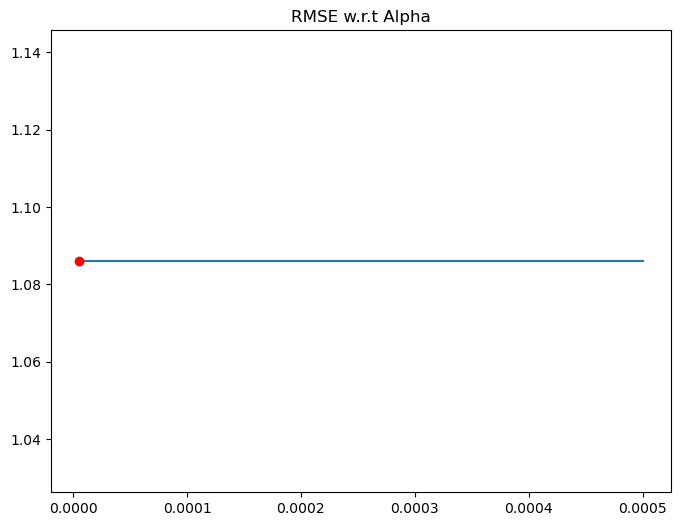

In [ ]:

alpha_values = np.linspace(0.000005, 0.0005, 100)
rmses = []

for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    ridge_pred = predict_score(ridge, X_test)
    rmses.append(mean_squared_error(y_test, ridge_pred, squared=False))

idx = np.argmin(rmses)
plt.figure(figsize=(10,6))
plt.plot(alpha_values, rmses)
plt.plot([alpha_values[idx]],rmses[idx], "ro")
plt.title("RMSE w.r.t Alpha(Ridge)")
plt.show()

In [ ]:
lin_reg3_pred

array([[5],
       [5],
       [3],
       ...,
       [5],
       [4],
       [4]])